SpM $\omega$
=============

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import sys
#sys.path.append("../../admmsolver/src/")

In [4]:
#from admmsolver.objectivefunc import ConstrainedLeastSquares, L2Regularizer, NonNegativePenalty
#from admmsolver.optimizer import SimpleOptimizer, Problem
#from admmsolver.matrix import identity, DiagonalMatrix
#from admmsolver.util import smooth_regularizer_coeff
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from typing import Optional
#import sparse_ir

In [5]:
from spmomega.solvers import AnaContSmooth

import numpy as np
from sparse_ir import FiniteTempBasis, KernelFFlat, MatsubaraSampling, TauSampling
import pytest

gaussian = lambda x, mu, sigma: np.exp(-((x-mu)/sigma)**2)/(np.sqrt(np.pi)*sigma)

# Three-Gaussian model from SpM paper
def rho(omega):
    res = 0.2*gaussian(omega, 0.0, 0.15) + \
        0.4*gaussian(omega, 1.0, 0.8) + 0.4*gaussian(omega, -1.0, 0.8)
    return res[:,None,None]

def get_singular_term_matsubara(
    type: Optional[str],
    ginput: np.ndarray,
    sampling_points: np.ndarray):
    if type == "HF":
        print("HF")
        return np.ones_like(ginput)
    elif type == "omega0":
        print("omega0")
        res = np.zeros_like(ginput)
        res[sampling_points==0, ...] = 1.0
        return res
    return np.zeros_like(ginput)

In [6]:
stat = "B"
augment = "omega0"
wmax = 10.0
beta = 100.0
niv = 1000
#shift = {"F": 1, "B": 0}[stat]
#vsample = 2*np.arange(-niv, niv) + shift

basis = FiniteTempBasis(stat, beta, wmax, eps=1e-12, kernel=KernelFFlat(beta*wmax))
vsample = basis.default_matsubara_sampling_points()
smpl_matsu = MatsubaraSampling(basis, vsample)

/home/vscode/work/sparse-ir/src/sparse_ir/basis.py:208: UserWarning: 
Basis cutoff is 1e-12, which is below sqrt(eps) with
eps = 2.2e-16.  Expect singular values and basis functions
for large l to have lower precision than the cutoff.
You can install the xprec package to gain more precision.

  u, s, v = sve.compute(self.kernel, eps)


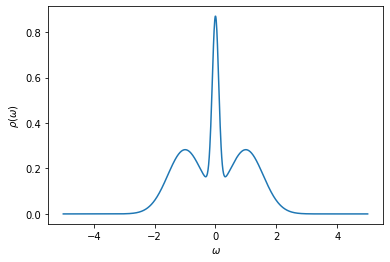

In [7]:
omegas = np.linspace(-5, 5, 1000)
plt.xlabel(r'$\omega$')
plt.ylabel(r'$\rho(\omega)$')
plt.plot(omegas, rho(omegas)[:,0,0])

In [8]:
# Compute exact rho_l, g_l, g_iv, g_tau
rho_test = rho(np.linspace(-1,1,100))
rho_l = basis.v.overlap(rho, axis=0)
rho_l = rho_l.reshape((basis.size,) + rho_test.shape[1:])
g_l = -basis.s[:,None,None] * rho_l

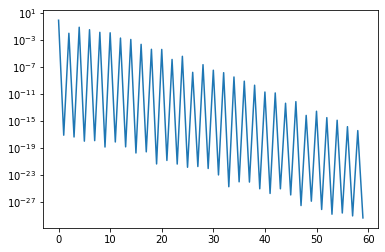

In [9]:
plt.semilogy(np.abs(g_l[:,0,0]))

In [10]:
# From Matsubara
g_iv = smpl_matsu.evaluate(g_l, axis=0)
print("augment", augment)
singular_term = get_singular_term_matsubara(augment, g_iv, vsample)
g_iv += singular_term
solver = AnaContSmooth(
    beta, wmax, stat, "freq", vsample, singular_term=augment)

alpha = 1e-8
rho_w, info = solver.solve(g_iv, alpha, niter=10000, spd=True)

augment omega0
omega0


/home/vscode/work/sparse-ir/src/sparse_ir/basis.py:208: UserWarning: 
Basis cutoff is 1e-15, which is below sqrt(eps) with
eps = 2.2e-16.  Expect singular values and basis functions
for large l to have lower precision than the cutoff.
You can install the xprec package to gain more precision.

  u, s, v = sve.compute(self.kernel, eps)


<sparse_ir.basis.FiniteTempBasis object at 0xffff4d75c160> [-6934 -6604 -6274 -1638  -858  -564  -410  -314  -248  -200  -164  -134
  -112   -92   -78   -64   -54   -46   -38   -32   -28   -24   -20   -18
   -16   -14   -12   -10    -8    -6    -4    -2     0     2     4     6
     8    10    12    14    16    18    20    24    28    32    38    46
    54    64    78    92   112   134   164   200   248   314   410   564
   858  1638  6274  6604  6934]
<sparse_ir.augment.LegendreBasis object at 0xffff4d68c070> [-6934 -6604 -6274 -1638  -858  -564  -410  -314  -248  -200  -164  -134
  -112   -92   -78   -64   -54   -46   -38   -32   -28   -24   -20   -18
   -16   -14   -12   -10    -8    -6    -4    -2     0     2     4     6
     8    10    12    14    16    18    20    24    28    32    38    46
    54    64    78    92   112   134   164   200   248   314   410   564
   858  1638  6274  6604  6934]


/usr/local/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


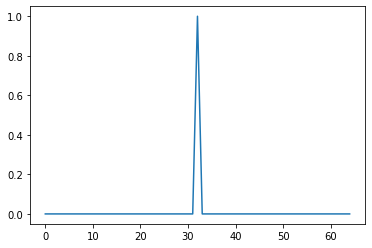

In [11]:
plt.plot(singular_term[:,0,0])

/usr/local/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(-4.0, 4.0)

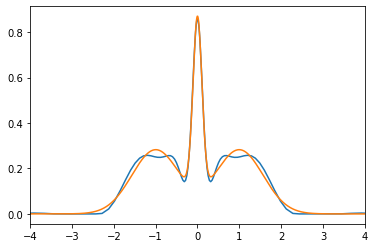

In [12]:
plt.plot(solver.smpl_real_w, rho_w[:solver.smpl_real_w.size, 0, 0])
plt.plot(omegas, rho(omegas)[:,0,0])
plt.xlim([-4,4])

In [13]:
rho_w[-1, 0, 0]

(0.9675410986939544-4.6171168607262554e-21j)

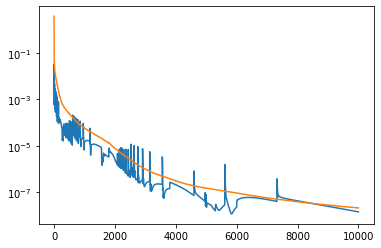

In [14]:
plt.semilogy(info["optimizer"]._primal_residual)
plt.semilogy(info["optimizer"]._dual_residual)